Import stuff

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy as sp
from matplotlib import scale
import matplotlib
from matplotlib.mlab import detrend
import scipy.fftpack as spfp
import scipy.signal as spsignal
from matplotlib.animation import FuncAnimation
import pandas as pd
from datetime import datetime, timedelta

Define time functions

In [50]:
# Function to convert C# ticks to Python datetime
def ticks_to_datetime(ticks):
    # Define the start date for ticks (0001-01-01 00:00:00 in Gregorian calendar)
    ticks_start_date = datetime(1, 1, 1)
    # Convert ticks to days (1 tick = 100 nanoseconds)
    days = ticks / (10**7 * 60 * 60 * 24)
    return ticks_start_date + timedelta(days=days)

# Function to load data and return data between two times


def get_data_between_times(filename, start_time, end_time):
    # Load data
    # Assuming the first row is a header
    data = np.loadtxt(filename, skiprows=1)

    # Convert the first column (timestamps) to datetime objects
    timestamps = np.array([ticks_to_datetime(tick) for tick in data[:, 0]])

    # Create a mask for the desired time range
    mask = (timestamps >= start_time) & (timestamps <= end_time)

    # Return the filtered data
    return data[mask]

Import data and assume sample rate

In [51]:
from os import truncate

sleep_data_filename = "/home/qcd/Desktop/repos/EEG/data/sleep.eer"
data =  np.loadtxt("/home/qcd/Desktop/repos/EEG/EEG/bin/Debug/net8.0/dump.eer")
#data = np.loadtxt(sleep_data_filename)
ydata = data[:,1]
#ydata = [(ydata[i]/pow(2,16)) for i in range(0, len(ydata))]
xdata = data[:,0]
print(data[:,1])
t_res = ticks_to_datetime(xdata[len(xdata)-1]-xdata[0])
freq_hz = t_res.microsecond / 1000  # 10k ticks per second
print("avg freq: {} hz".format(freq_hz))
print("{} samples ({})".format(len(xdata), t_res.time()))

[ 644.  528.  452. ... 1023. 1023. 1023.]
avg freq: 793.498 hz
138239 samples (14:56:00.793498)


Define other functions for charting and signal processing

In [52]:
def spectrogram(data, title, Fs=freq_hz):
    fig, (ax1,ax2,ax3) = plt.subplots(3)
    fig.set_figheight(15)
    fig.suptitle(title)
    [spectrum, freqs, t, im] = ax1.specgram(
        data, Fs=Fs, cmap=plt.cm.jet, mode='magnitude', xextent=[0, 50])
    #ax1.set_xlabel('Frequency [Hz]')
    ax2.plot(spectrum)
    ax2.set_title('Spectrum')
    ax3.set_title('PSD')
    ax3.psd(data, Fs=freq_hz, NFFT=pow(2, 8))
    ax3.plot()


def band_pass_filter(signal, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = spsignal.butter(order, [low, high], btype='band')
    y = spsignal.filtfilt(b, a, signal)
    return y

Load sleep data

In [53]:
# start_time = pd.to_datetime('today').replace(
#     hour=8, minute=0, second=0, microsecond=0)
# end_time = pd.to_datetime('today').replace(
#     hour=10, minute=0, second=0, microsecond=0)

# target_data = get_data_between_times(
#     sleep_data_filename, start_time, end_time)

Chart sleep data while targeting specific bands

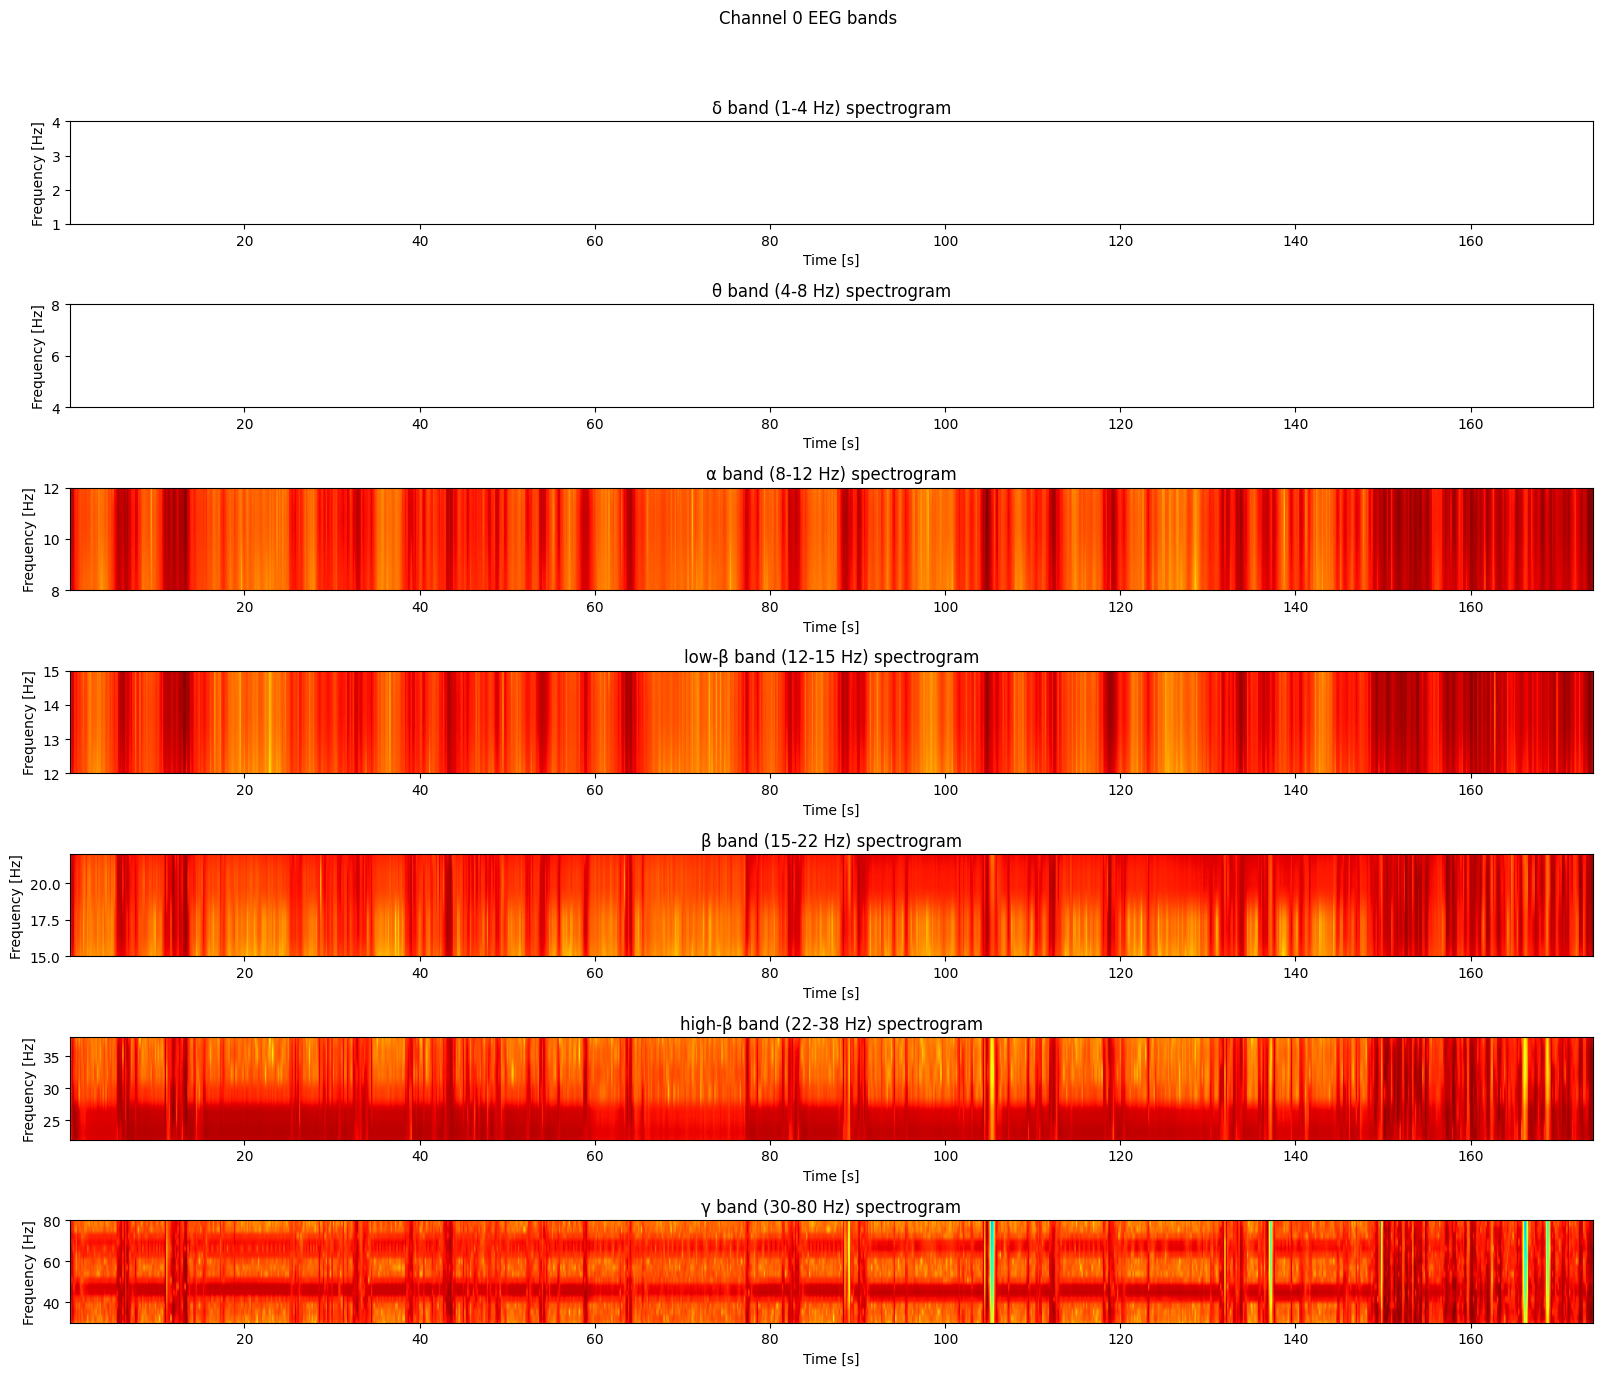

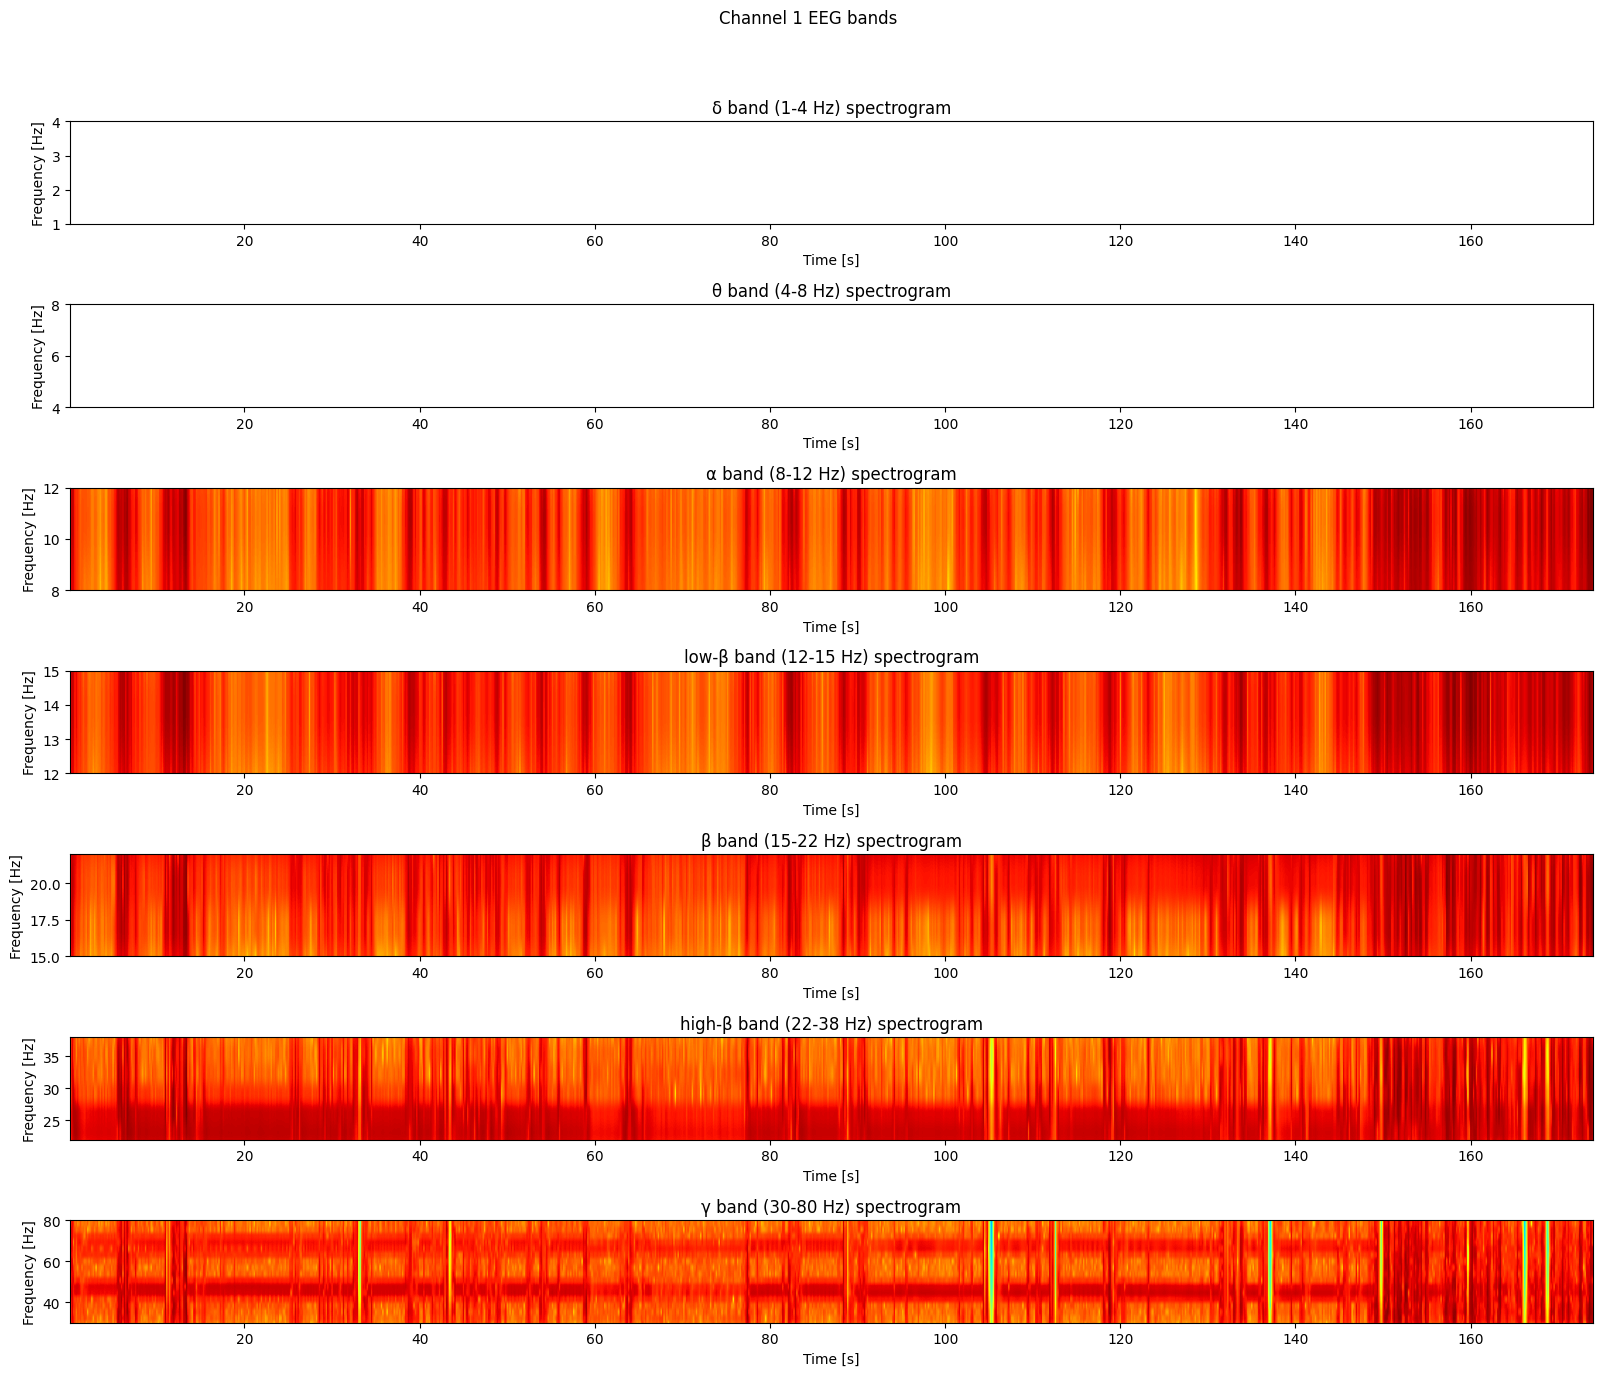

In [54]:
eeg_bands = {
    'δ': (1, 4),
    'θ': (4, 8),
    'α': (8, 12),
    'low-β': (12, 15),
    'β': (15, 22),
    'high-β': (22, 38),
    'γ': (30, 80)
    }

cutoff_freq = 80

def ch_analysis(channel, fft_res=256):
    global data, freq_hz  # Assuming these are defined elsewhere
    ch_data = data[:,channel+1]  # data[:, channel+1]
    # low_pass_filter(ch_data, cutoff_freq, freq_hz)
    ch_data_filtered = ch_data

    num_bands = len(eeg_bands)
    fig, axs = plt.subplots(num_bands, 1, figsize=(16, 2 * num_bands))

    for i, (band, (low, high)) in enumerate(eeg_bands.items()):
        ax = axs[i]
        band_data = band_pass_filter(ch_data_filtered, low, high, freq_hz)
        ax.set_title('{} band ({}-{} Hz) spectrogram'.format(band, low, high))
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Frequency [Hz]')
        spectrum, freqs, t, im = ax.specgram(
            band_data, Fs=freq_hz, cmap=plt.cm.jet, mode='psd', scale="dB", NFFT=fft_res, noverlap=int(fft_res/2))
        ax.set_ylim(low, high)

    fig.suptitle("Channel {} EEG bands".format(channel))
    fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
    plt.show()

ch_analysis(0)
ch_analysis(1)

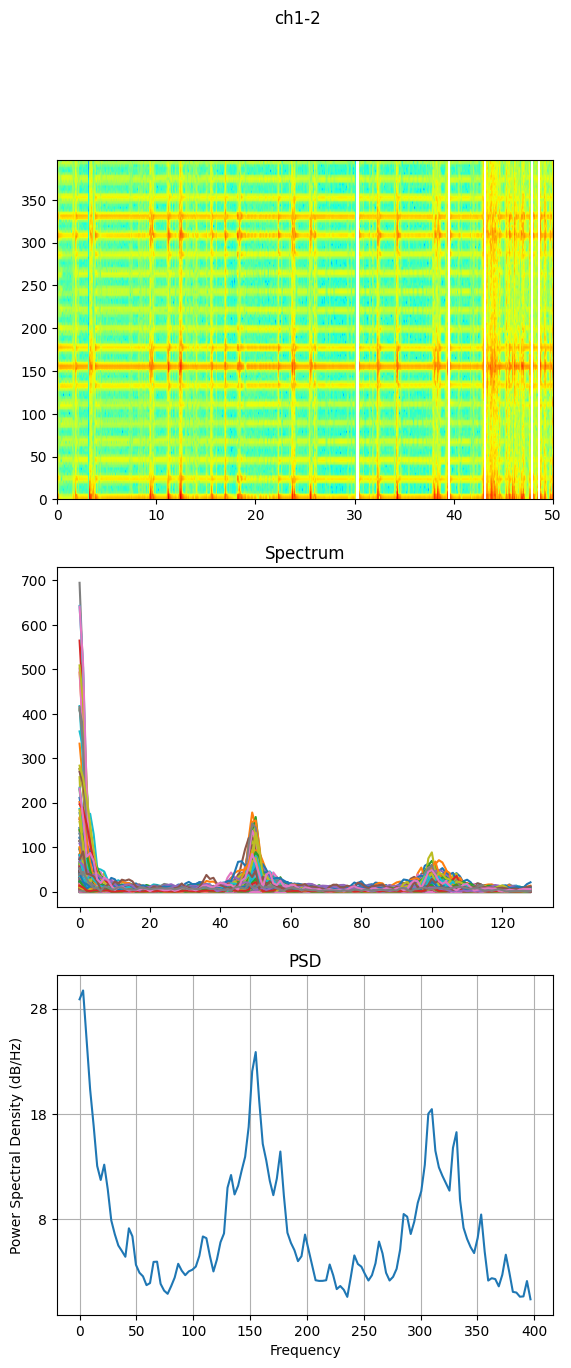

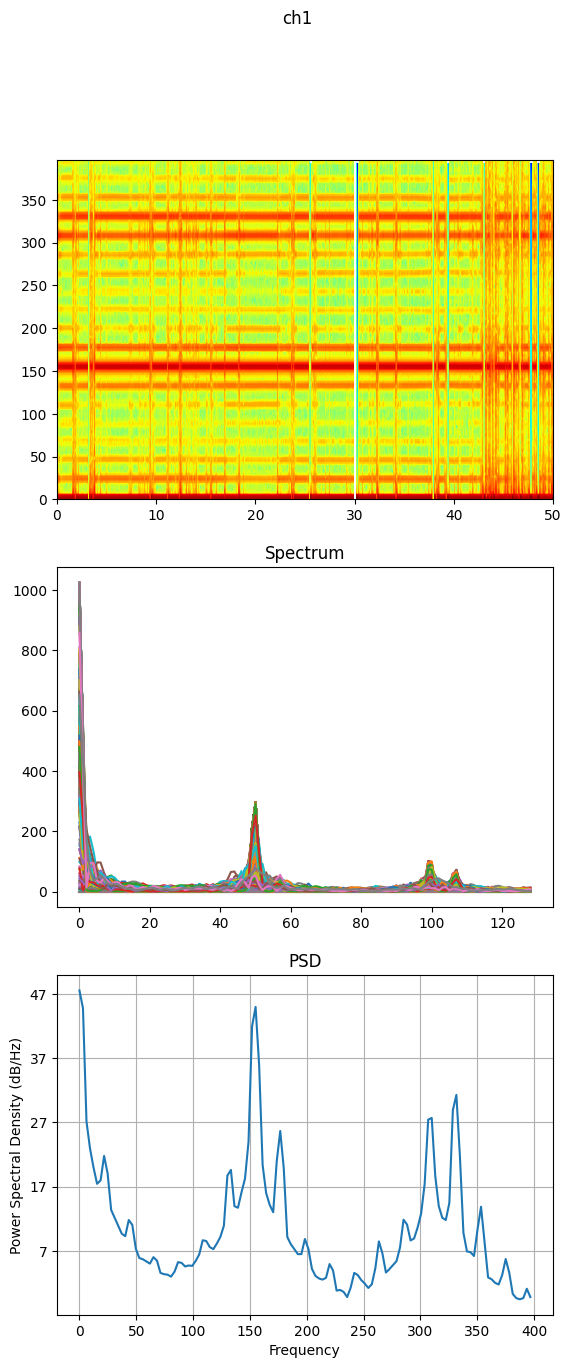

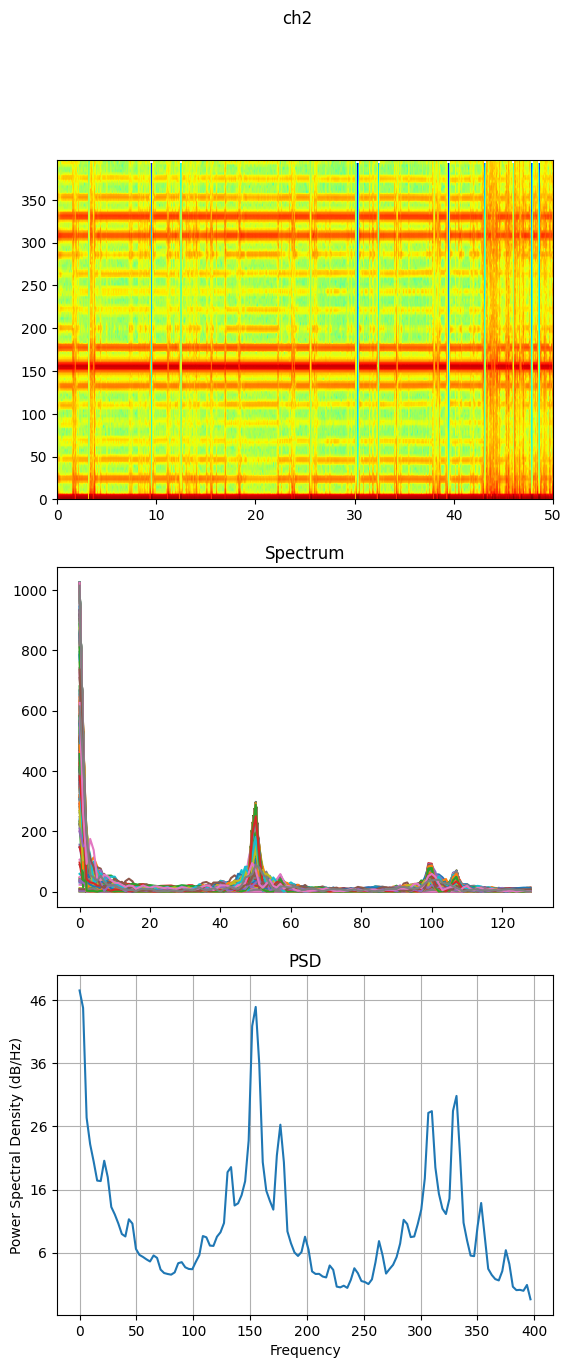

In [55]:
spectrogram(data[:,1]-data[:,2], "ch1-2")
spectrogram(data[:,1], "ch1")
spectrogram(data[:,2], "ch2")